In [1]:
import os
os.chdir('../ComfyUI')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Jul 17 21:30:03 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 37%   24C    P8    28W / 350W |  11206MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:23:00.0 Off |                  N/A |
| 36%   

### Load Nodes

In [5]:
import comfy
from nodes import init_external_custom_nodes, NODE_CLASS_MAPPINGS

init_external_custom_nodes()

NODE_CLASS_MAPPINGS

Total VRAM 24260 MB, total RAM 257782 MB
pytorch version: 2.3.1+cu121
Set vram state to: NORMAL_VRAM
Device: cuda:0 NVIDIA GeForce RTX 3090 : native
Using pytorch cross attention

Import times for custom nodes:
   0.0 seconds: /home/gaudio/ste/projects/lsd/ComfyUI/custom_nodes/websocket_image_save.py



{'KSampler': nodes.KSampler,
 'CheckpointLoaderSimple': nodes.CheckpointLoaderSimple,
 'CLIPTextEncode': nodes.CLIPTextEncode,
 'CLIPSetLastLayer': nodes.CLIPSetLastLayer,
 'VAEDecode': nodes.VAEDecode,
 'VAEEncode': nodes.VAEEncode,
 'VAEEncodeForInpaint': nodes.VAEEncodeForInpaint,
 'VAELoader': nodes.VAELoader,
 'EmptyLatentImage': nodes.EmptyLatentImage,
 'LatentUpscale': nodes.LatentUpscale,
 'LatentUpscaleBy': nodes.LatentUpscaleBy,
 'LatentFromBatch': nodes.LatentFromBatch,
 'RepeatLatentBatch': nodes.RepeatLatentBatch,
 'SaveImage': nodes.SaveImage,
 'PreviewImage': nodes.PreviewImage,
 'LoadImage': nodes.LoadImage,
 'LoadImageMask': nodes.LoadImageMask,
 'ImageScale': nodes.ImageScale,
 'ImageScaleBy': nodes.ImageScaleBy,
 'ImageInvert': nodes.ImageInvert,
 'ImageBatch': nodes.ImageBatch,
 'ImagePadForOutpaint': nodes.ImagePadForOutpaint,
 'EmptyImage': nodes.EmptyImage,
 'ConditioningAverage': nodes.ConditioningAverage,
 'ConditioningCombine': nodes.ConditioningCombine,
 'Con

In [6]:
checkpoint_loader_simple = NODE_CLASS_MAPPINGS['CheckpointLoaderSimple']()
clip_text_encode = NODE_CLASS_MAPPINGS['CLIPTextEncode']()
ksampler = NODE_CLASS_MAPPINGS['KSampler']()
empty_latent_image = NODE_CLASS_MAPPINGS['EmptyLatentImage']()
vae_encode = NODE_CLASS_MAPPINGS['VAEEncode']()
vae_decode = NODE_CLASS_MAPPINGS['VAEDecode']()

### Model Load

In [7]:
!ls /data/sd_files/checkpoint

beautifulRealistic_v7.safetensors  beautifulRealistic_v7.safetensors.1


In [8]:
import torch.nn.functional as F

# ln -s /data/sd_files/checkpoint/beautifulRealistic_v7.safetensors
with torch.no_grad():
    checkpoint_path = '/beautifulRealistic_v7.safetensors'
    model, clip, vae = checkpoint_loader_simple.load_checkpoint(checkpoint_path)
    
print('done')

model_type EPS
Using pytorch attention in VAE
Using pytorch attention in VAE


done


In [9]:
# show samplers list
comfy.samplers.KSampler.SAMPLERS

['euler',
 'euler_cfg_pp',
 'euler_ancestral',
 'euler_ancestral_cfg_pp',
 'heun',
 'heunpp2',
 'dpm_2',
 'dpm_2_ancestral',
 'lms',
 'dpm_fast',
 'dpm_adaptive',
 'dpmpp_2s_ancestral',
 'dpmpp_sde',
 'dpmpp_sde_gpu',
 'dpmpp_2m',
 'dpmpp_2m_sde',
 'dpmpp_2m_sde_gpu',
 'dpmpp_3m_sde',
 'dpmpp_3m_sde_gpu',
 'ddpm',
 'lcm',
 'ipndm',
 'ipndm_v',
 'deis',
 'ddim',
 'uni_pc',
 'uni_pc_bh2']

In [10]:
# show samplers scheduler
comfy.samplers.KSampler.SCHEDULERS

['normal', 'karras', 'exponential', 'sgm_uniform', 'simple', 'ddim_uniform']

In [11]:
from PIL import Image

def get_image(prompt, n_prompt, width=512, height=512, steps=20, cfg=7.0,
              sampler_name='dpmpp_2m_sde', scheduler='karras'):
    with torch.no_grad():
        
        positive = clip_text_encode.encode(clip, prompt)[0]
        negative = clip_text_encode.encode(clip, n_prompt)[0]
        
        '''Make Image'''      
        latent = empty_latent_image.generate(width, height, 1)[0]
        seed = np.random.randint(0xffffffff)
        latent = ksampler.sample(model, seed, steps, cfg,
                                 comfy.samplers.KSampler.SAMPLERS.index(sampler_name),
                                 comfy.samplers.KSampler.SCHEDULERS.index(scheduler),
                                 positive, negative, latent)[0]
        image = vae_decode.decode(vae, latent)[0]

        image = Image.fromarray((image[0].data.cpu().numpy()*255).astype(np.uint8))
    return image

  0%|          | 0/20 [00:00<?, ?it/s]

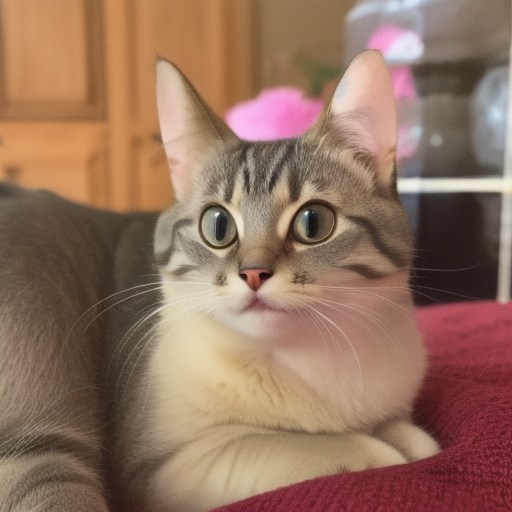

In [13]:
prompt = 'A cute cat'
n_prompt = 'catoon, low quality'
get_image(prompt, n_prompt)